# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import glob

from PIL import ImageGrab, Image

import numpy as np

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



tensor(5)


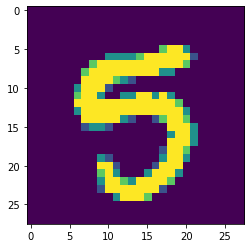

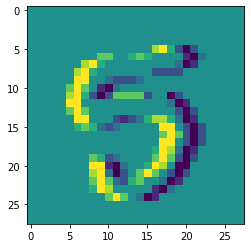

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [4]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.563258
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.488181
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302157
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315815
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383989
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156034
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164482
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.424047
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.307674
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.170113


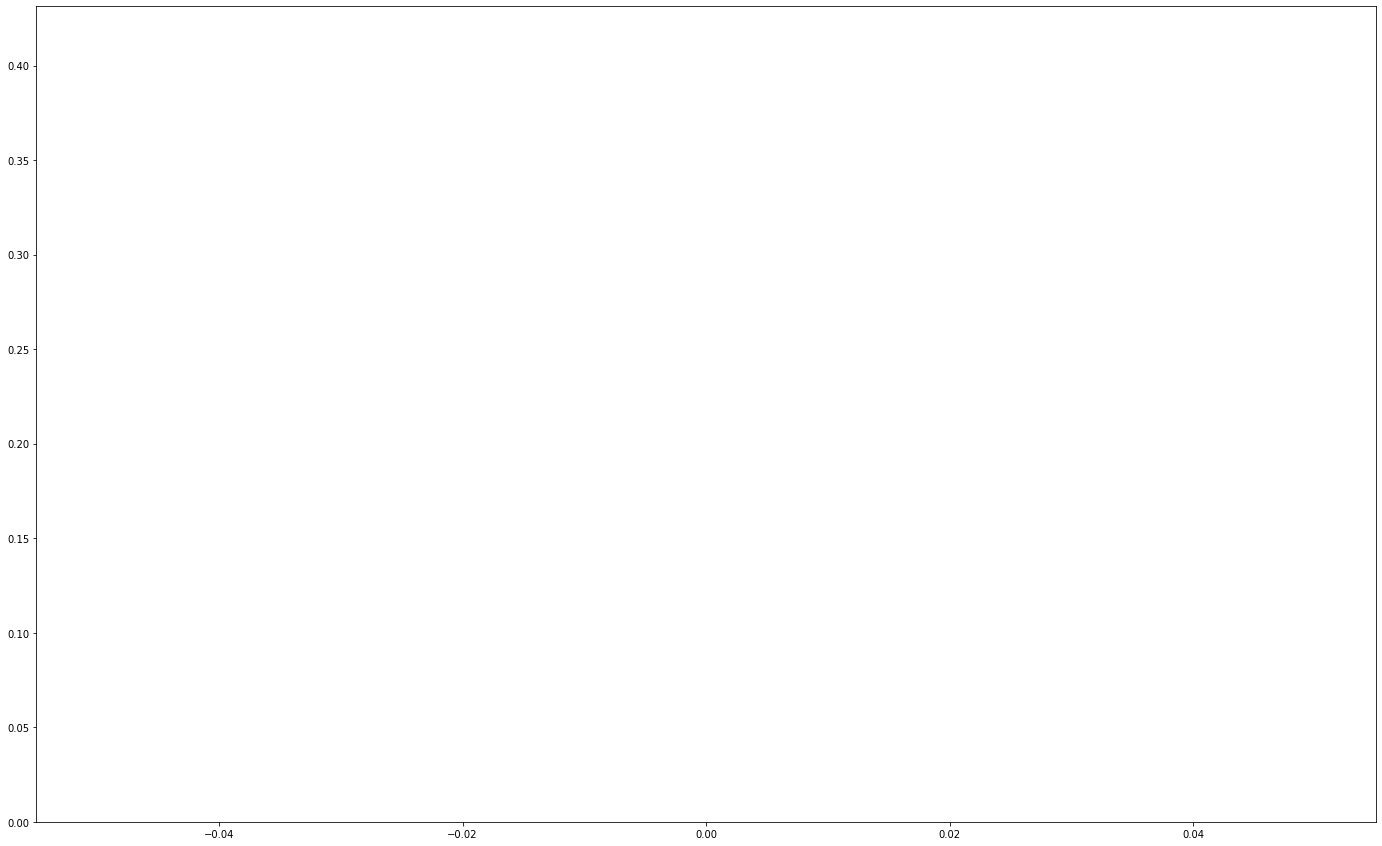

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.170806
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.089950
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.155377
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.254191
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163945
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.256645
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.201252
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.238038
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112839
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.065676
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.133926
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.120776


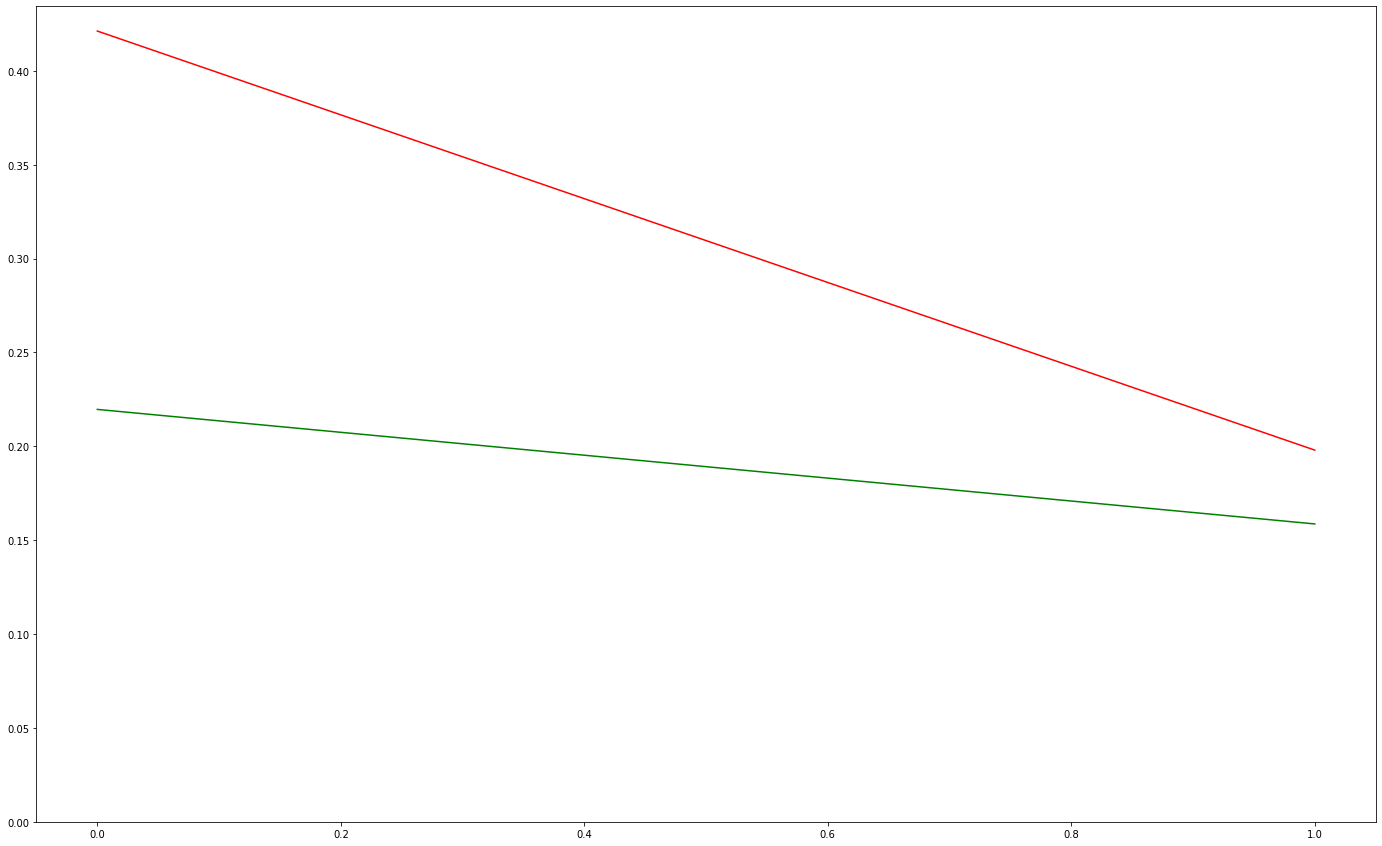

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168028
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.074631
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.133128
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.182101
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.101462
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.208186
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.197702
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.108310
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.126304
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.113163
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.081289
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.115443


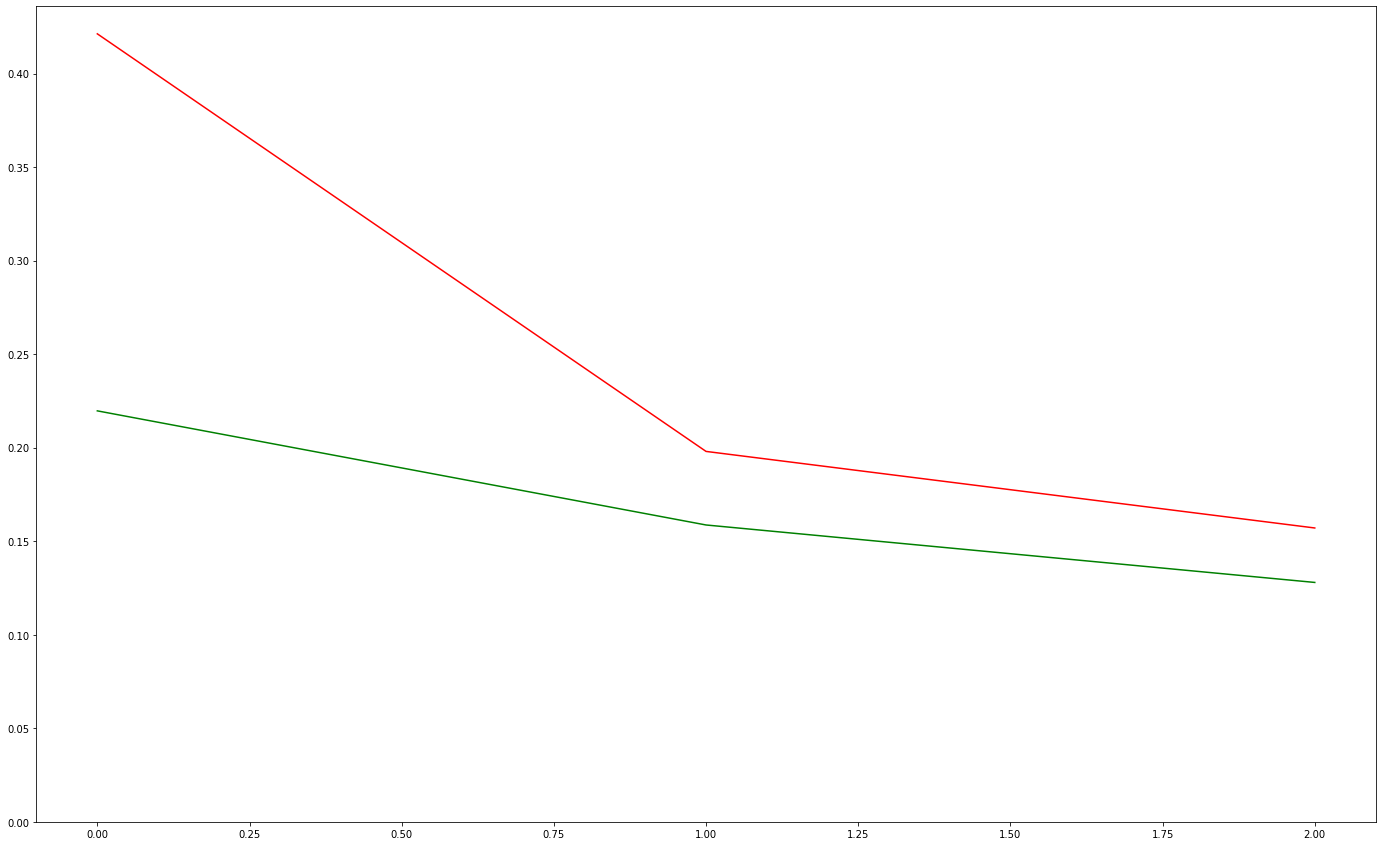

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.089903
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.071507
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.161049
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.134149
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.046448
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.106379
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.144144
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.231453
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.085462
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.048289
Train Epoch: 4 [0/10000 (0%)]	Loss: 0.126247
Train Epoch: 4 [6400/10000 (64%)]	Loss: 0.107565


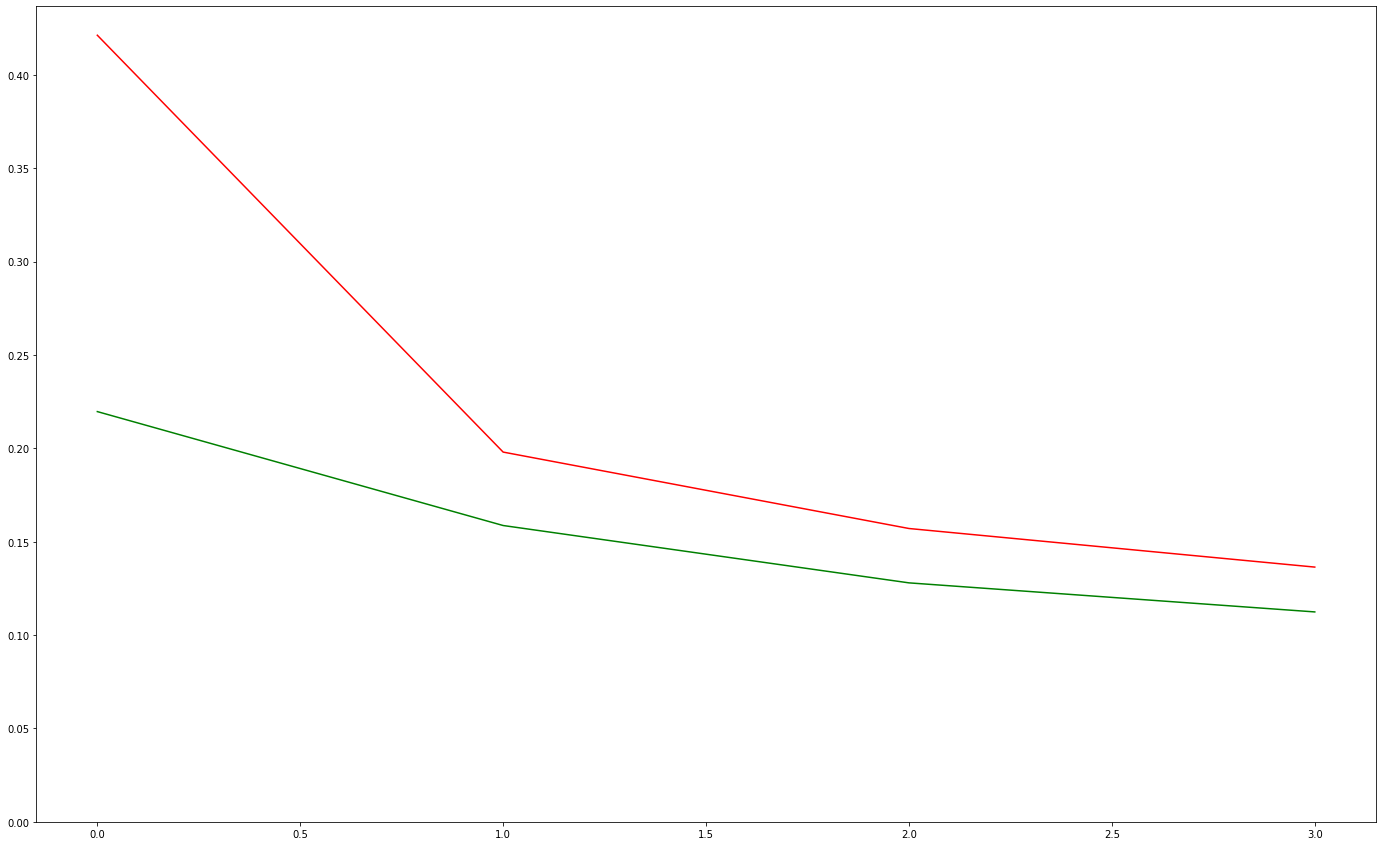

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.265280
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.081229
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.090159
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.107108
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.146385
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.095121
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.213207
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.137575
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.096118
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.046854
Train Epoch: 5 [0/10000 (0%)]	Loss: 0.117461
Train Epoch: 5 [6400/10000 (64%)]	Loss: 0.046005


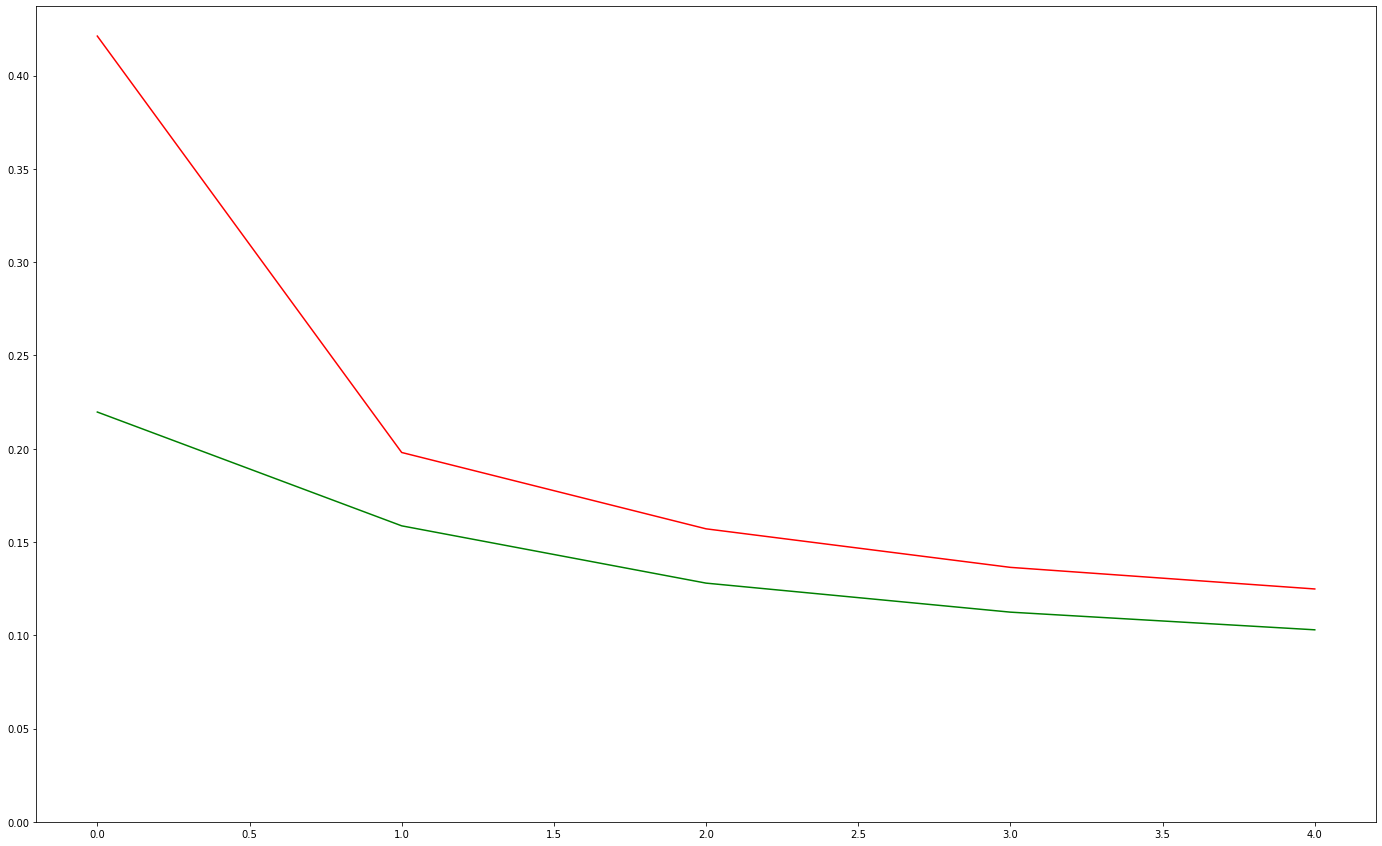

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.140353
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.140175
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.105317
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.186613
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.058053
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.100140
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.110772
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.054709
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.121826
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.044382
Train Epoch: 6 [0/10000 (0%)]	Loss: 0.178057
Train Epoch: 6 [6400/10000 (64%)]	Loss: 0.121625


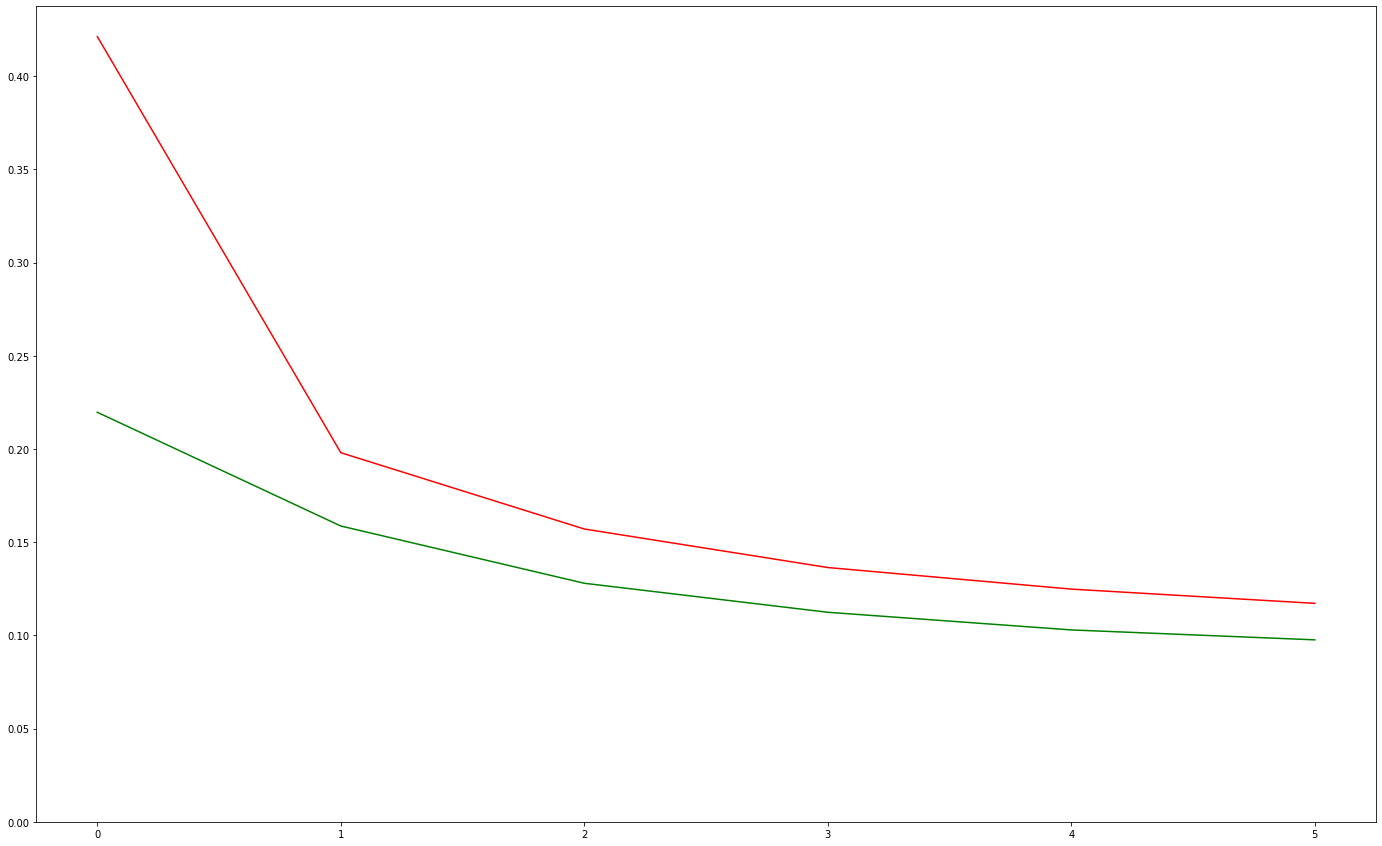

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.050530
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.107817
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.030834
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.098258
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.143314
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.073352
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.090642
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.112816
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.211800
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.039701
Train Epoch: 7 [0/10000 (0%)]	Loss: 0.118487
Train Epoch: 7 [6400/10000 (64%)]	Loss: 0.042419


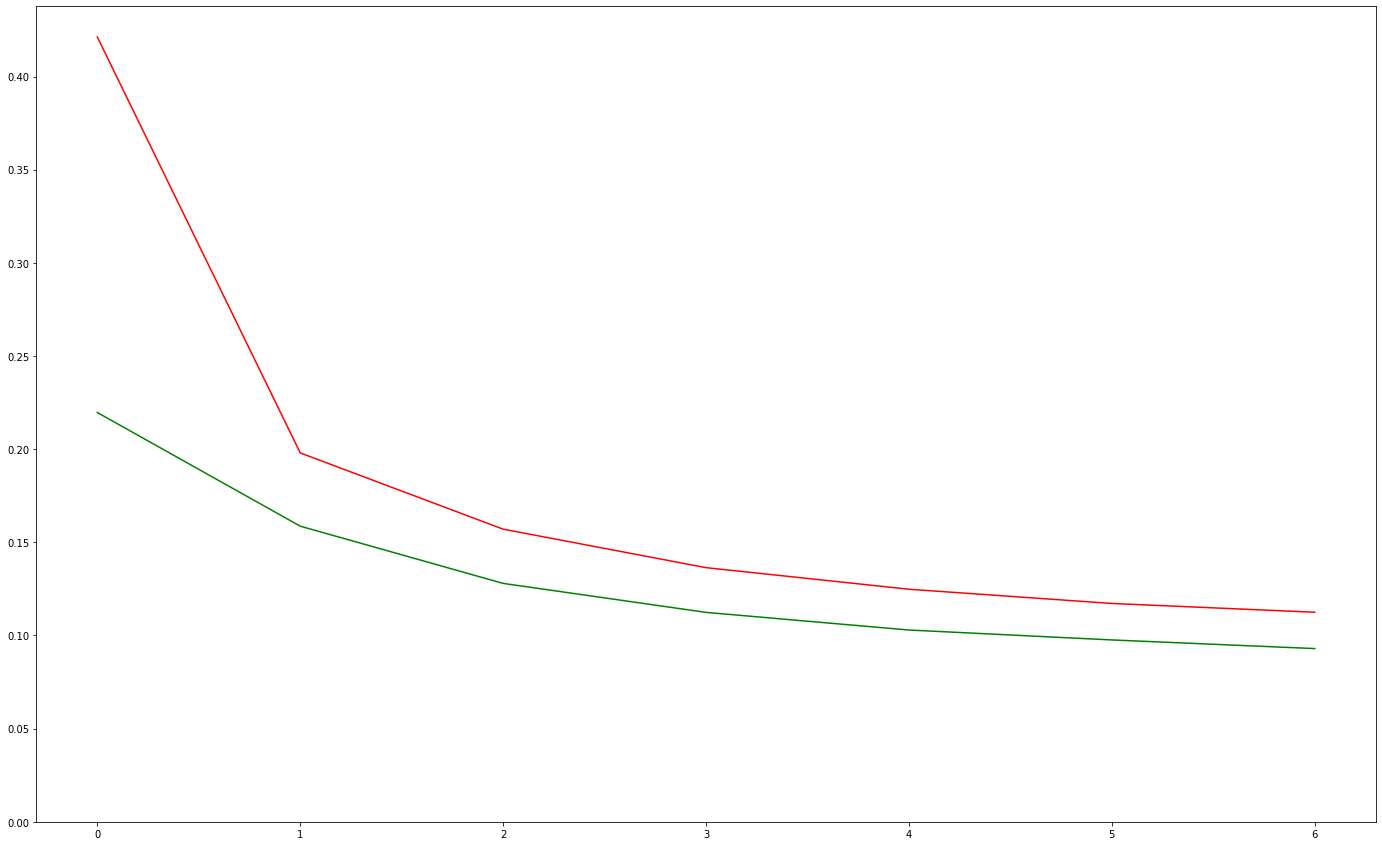

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.071041
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.083250
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.319673
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.095723
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.091965
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.087577
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.044498
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.227669
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.222089
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.205142
Train Epoch: 8 [0/10000 (0%)]	Loss: 0.197020
Train Epoch: 8 [6400/10000 (64%)]	Loss: 0.089956


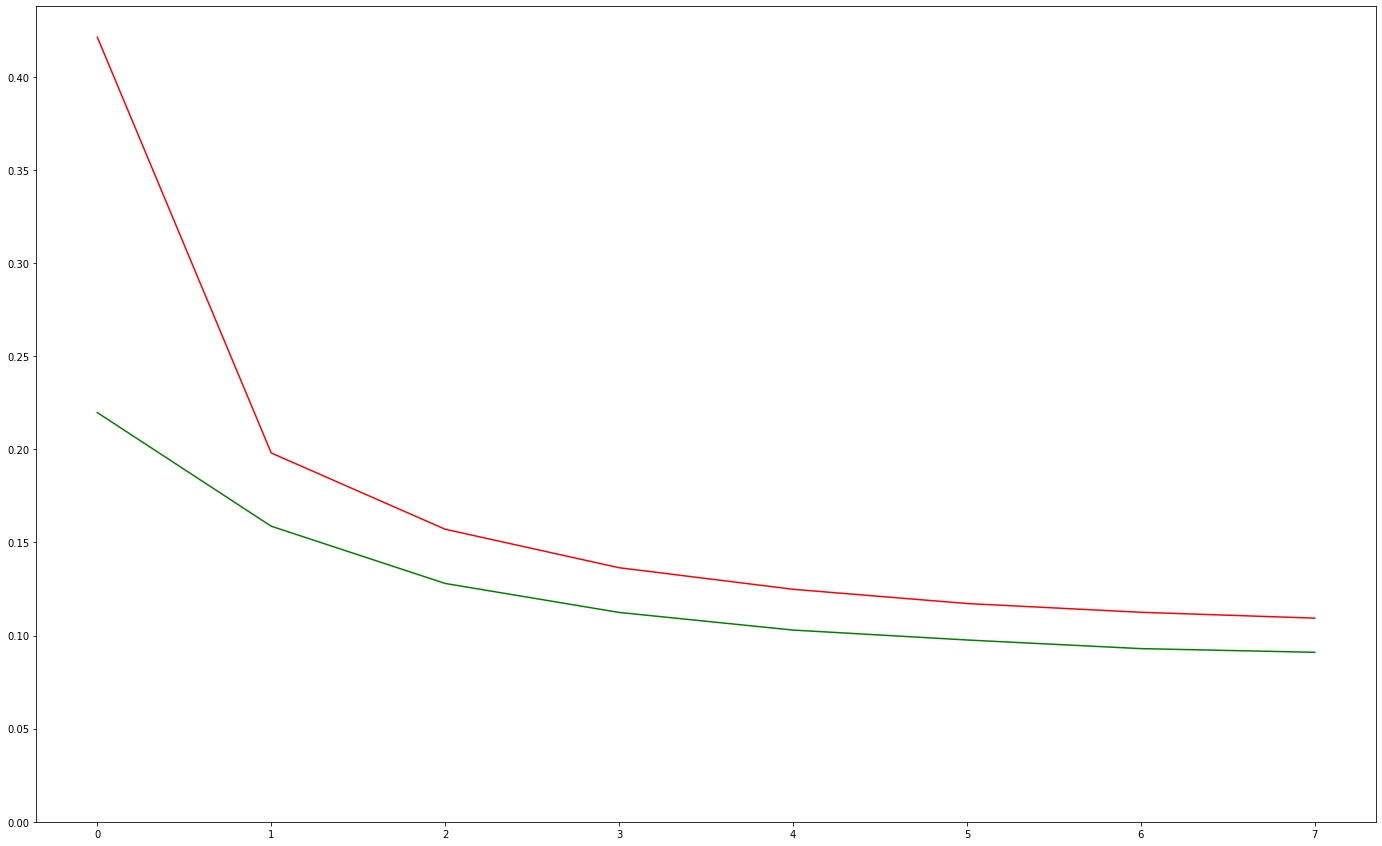

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.158753
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.053285
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.139322
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.180446
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.210323
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.068156
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.268404
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.018822
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.254371
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.203172
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.094717
Train Epoch: 9 [6400/10000 (64%)]	Loss: 0.022668


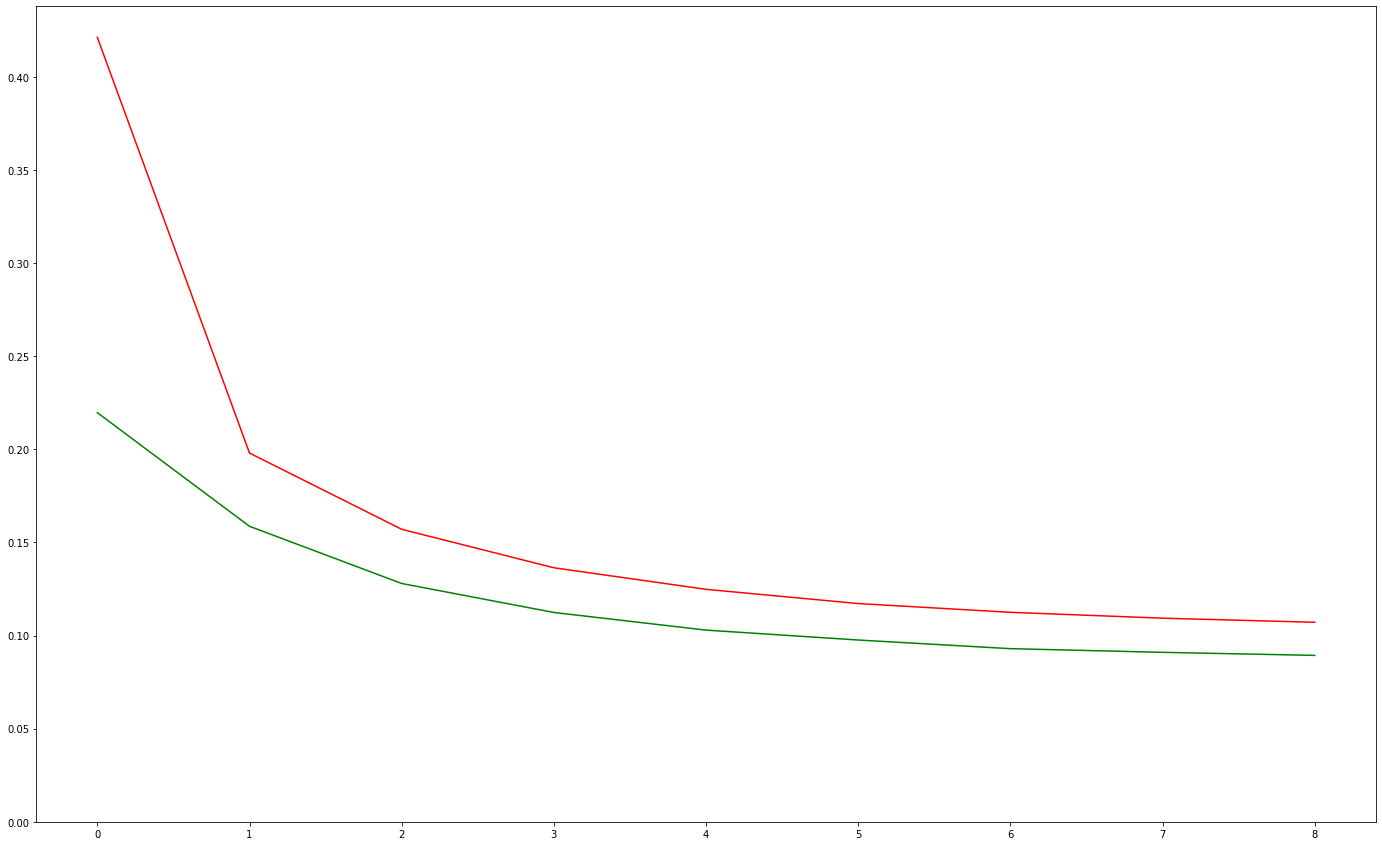

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.129165
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.109433
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.258332
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.073542
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.084949
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.075783
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.057408
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.029490
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.026378
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.091585
Train Epoch: 10 [0/10000 (0%)]	Loss: 0.100450
Train Epoch: 10 [6400/10000 (64%)]	Loss: 0.102873


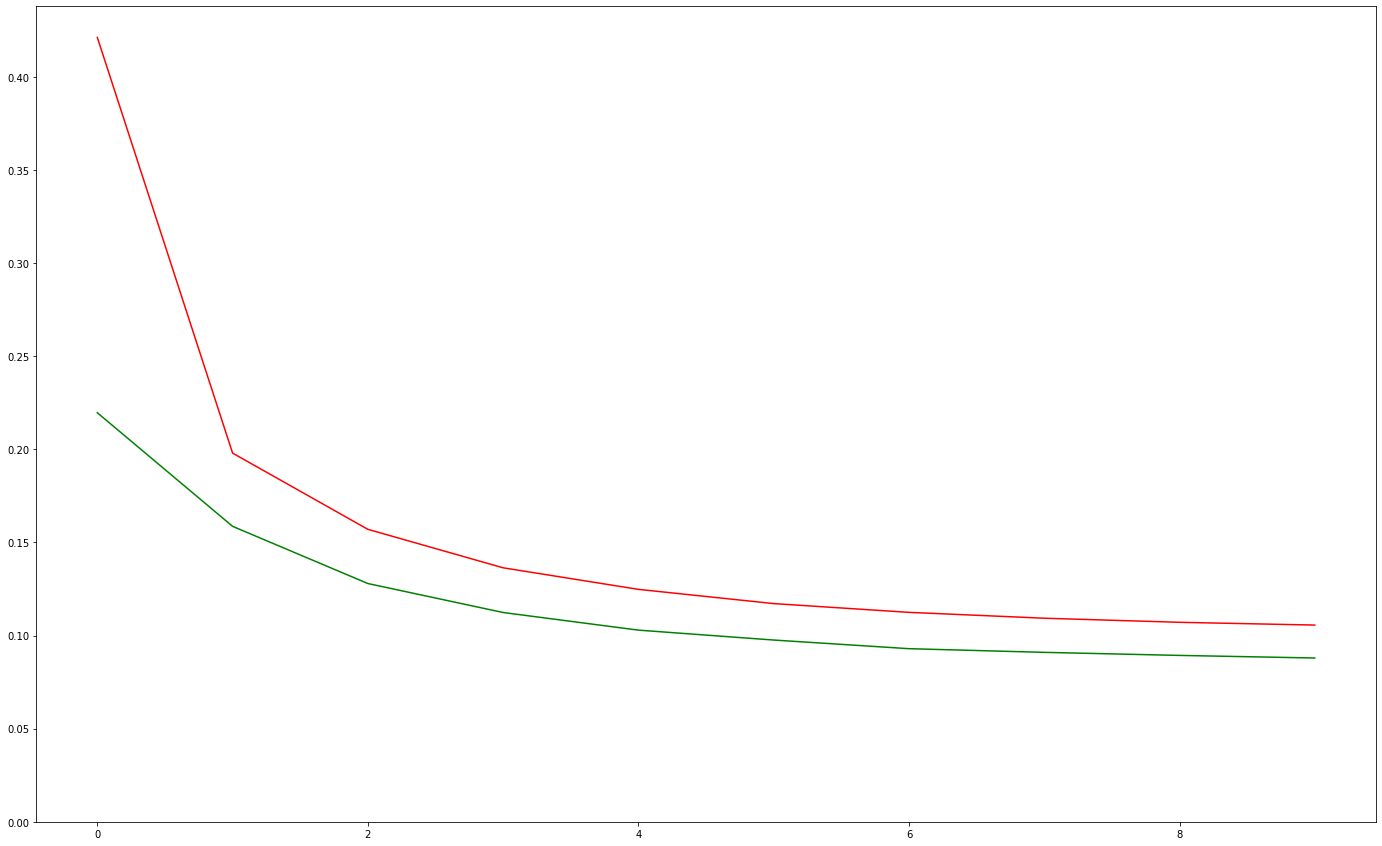

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.098961
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.118632
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.038462
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.200112
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.073380
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.086090
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.041244
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.084376
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.165234
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.114708
Train Epoch: 11 [0/10000 (0%)]	Loss: 0.051801
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.132342


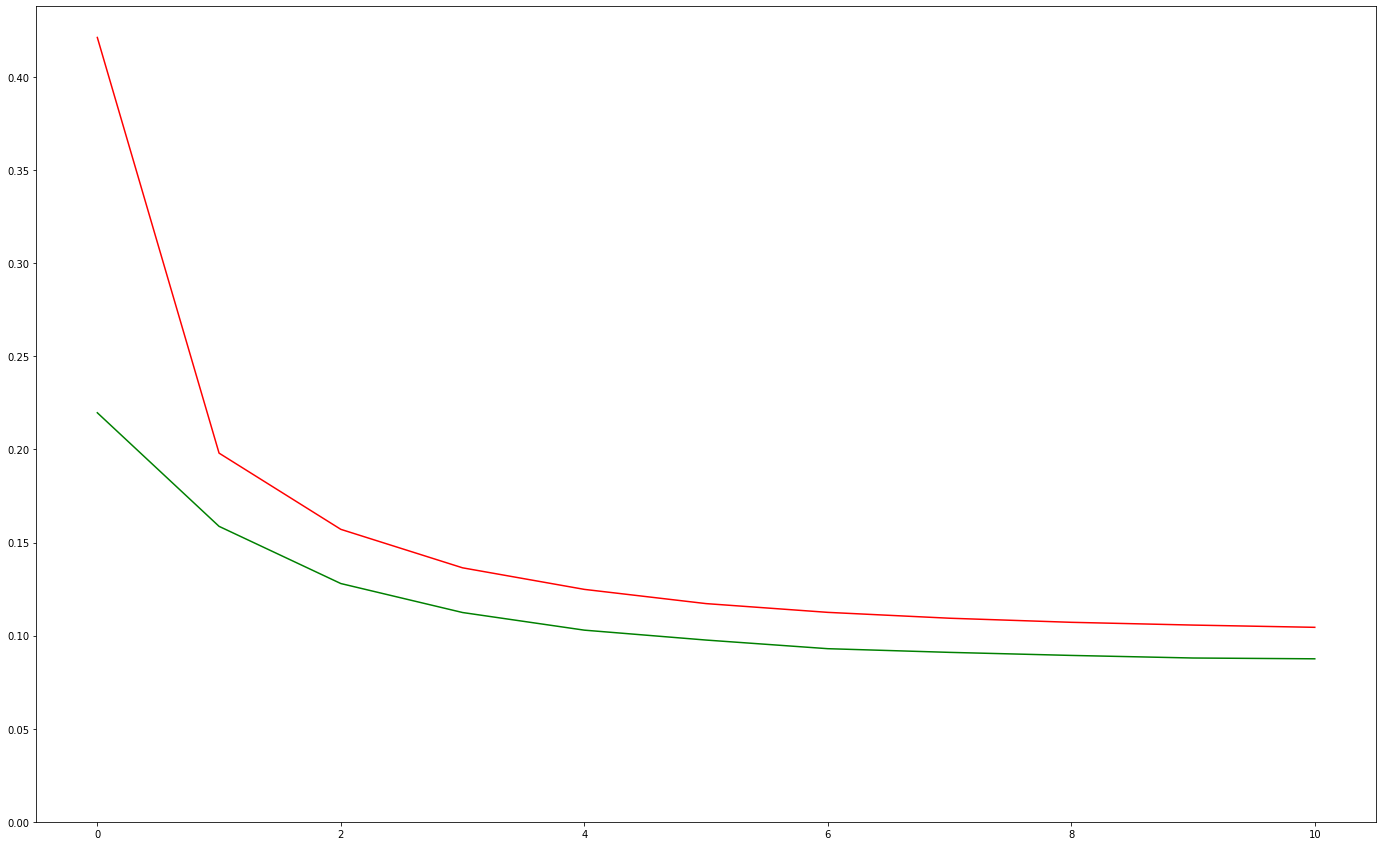

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.139998
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.130212
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.114917
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.015921
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.114757
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.099982
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.100067
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.341742
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.047859
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.052092
Train Epoch: 12 [0/10000 (0%)]	Loss: 0.026055
Train Epoch: 12 [6400/10000 (64%)]	Loss: 0.156441


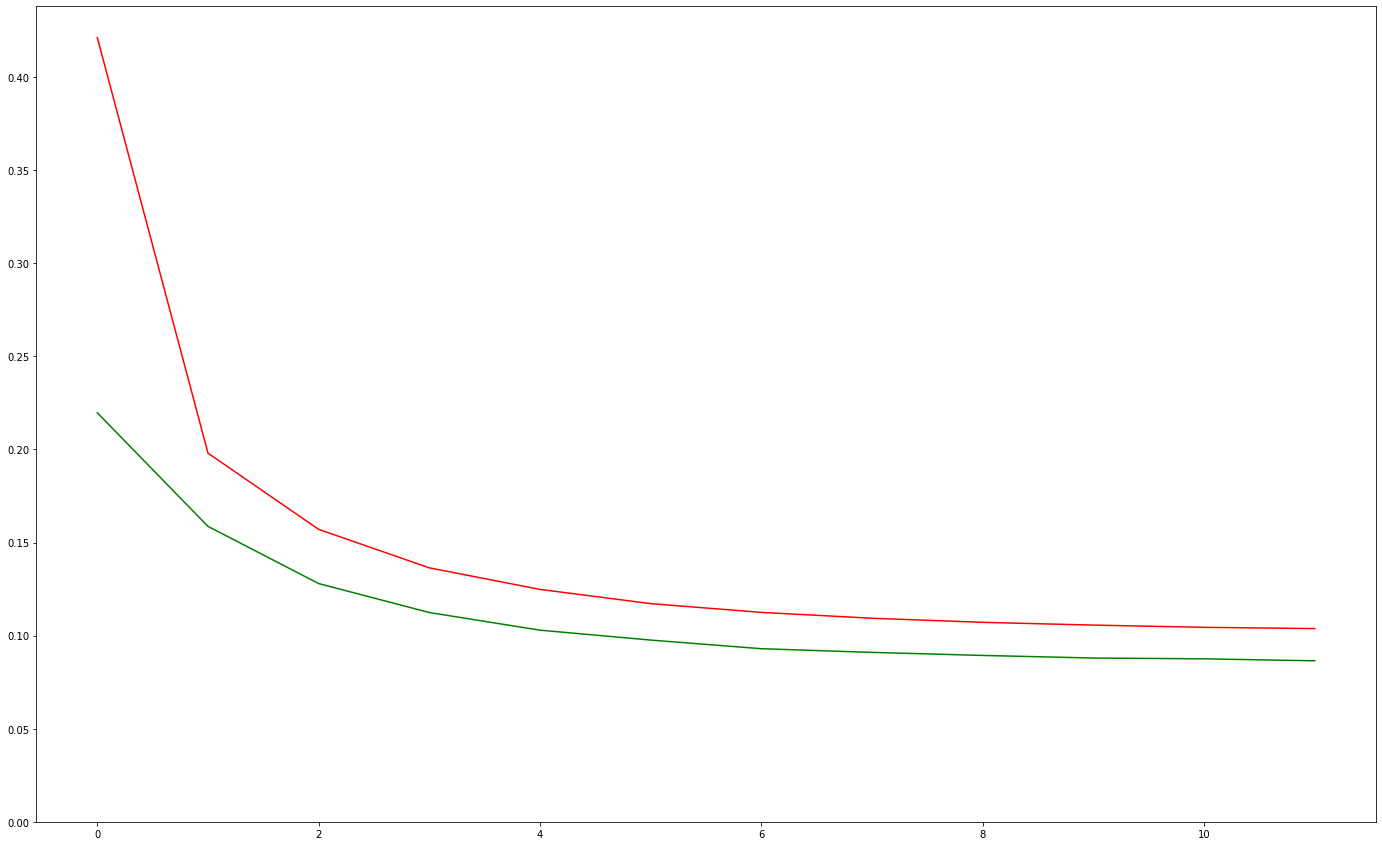

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.145154
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.159324
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.109540
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.062472
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.143895
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.203298
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.028169
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.041671
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.163417
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.034740
Train Epoch: 13 [0/10000 (0%)]	Loss: 0.067061
Train Epoch: 13 [6400/10000 (64%)]	Loss: 0.028432


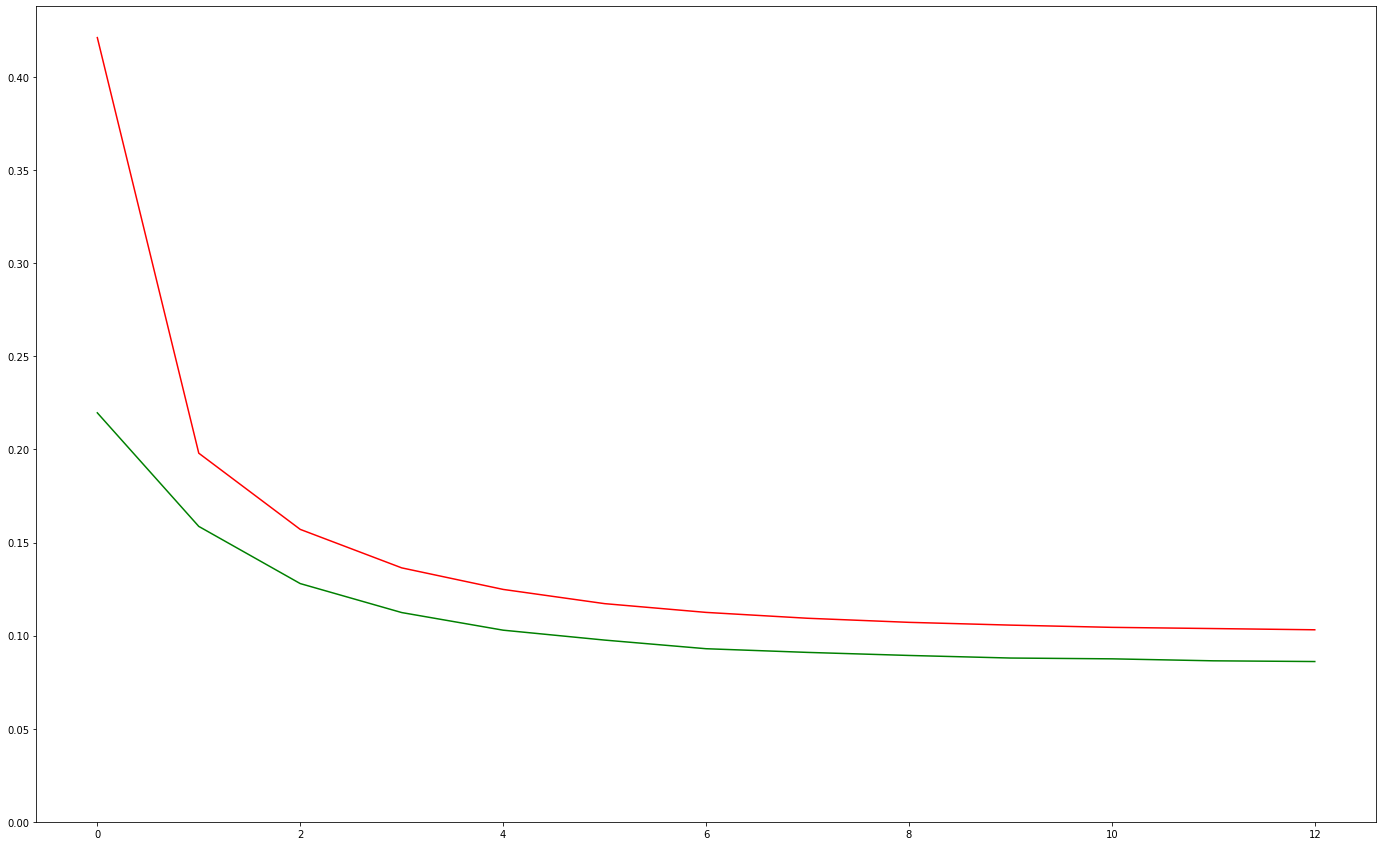

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.046780
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.087580
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.096331
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.050945
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.149258
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.037062
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.108271
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.065709
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.037986
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.131775
Train Epoch: 14 [0/10000 (0%)]	Loss: 0.078918
Train Epoch: 14 [6400/10000 (64%)]	Loss: 0.035192


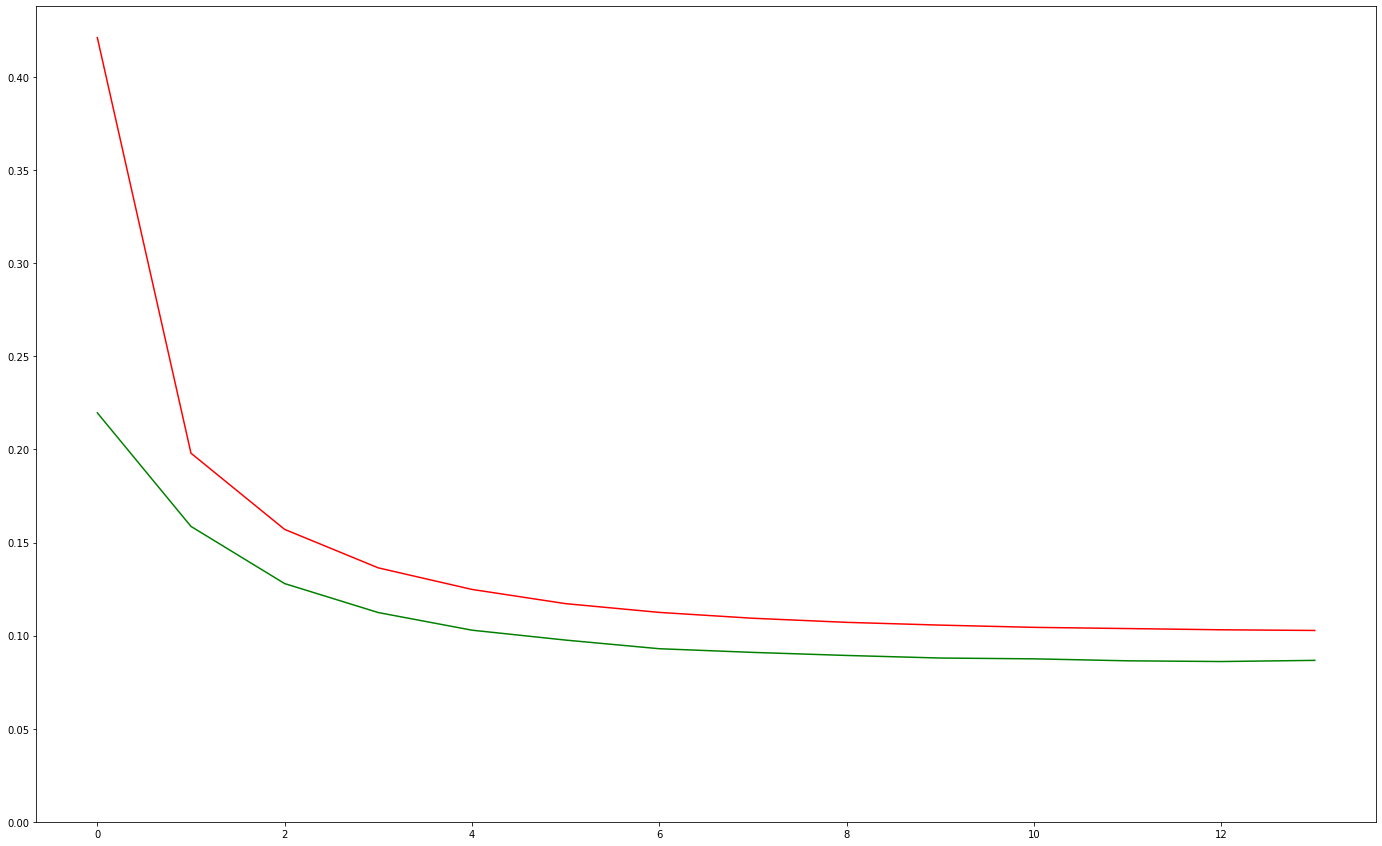

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.135915
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.166039
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.193478
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.030949
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.109301
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.118271
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.037196
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.087310
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.117622
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.114798
Train Epoch: 15 [0/10000 (0%)]	Loss: 0.061445
Train Epoch: 15 [6400/10000 (64%)]	Loss: 0.026343


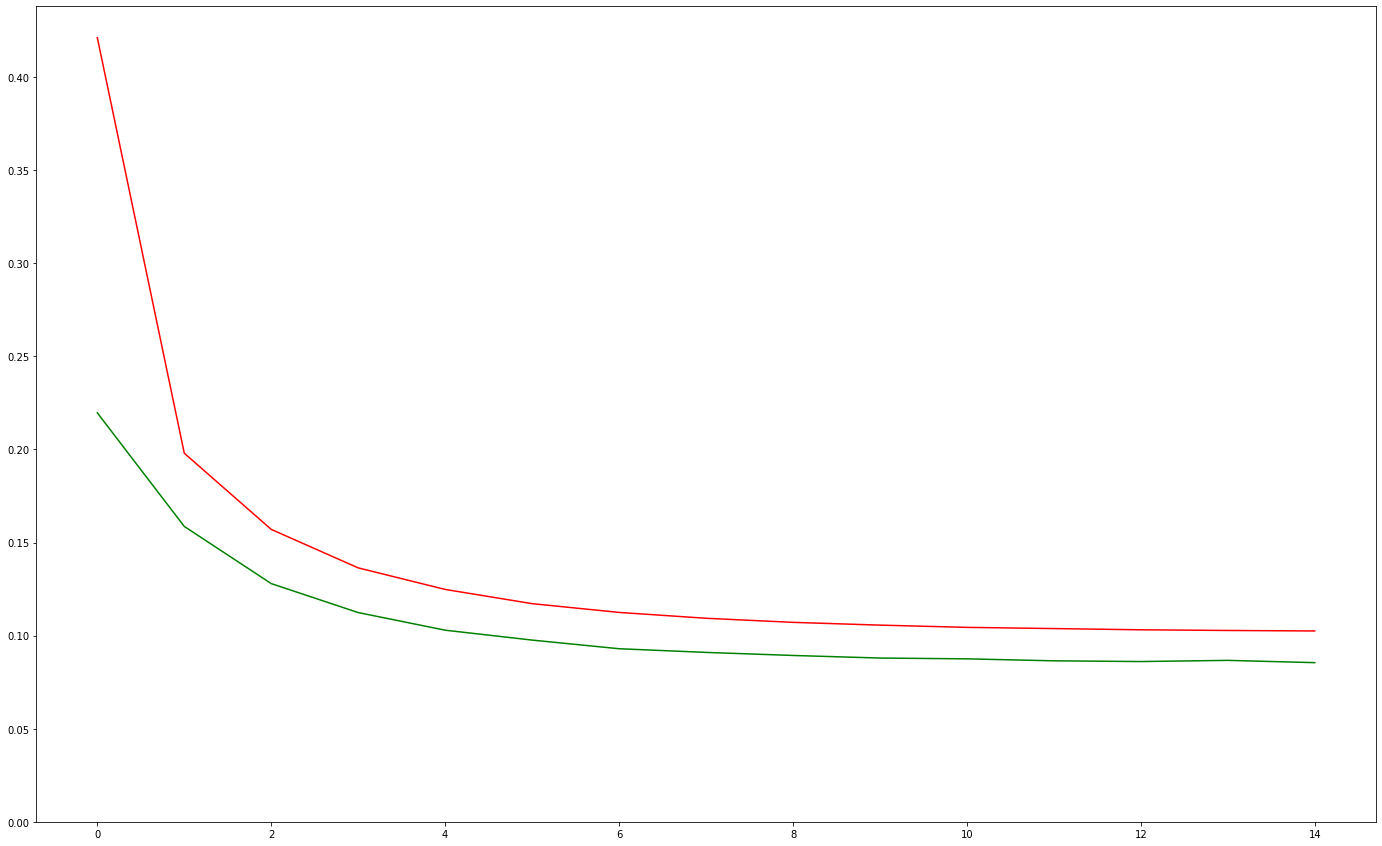

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.243580
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.107873
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.048105
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.052595
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.075623
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.067822
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.092267
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.092330
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.109391
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.130739
Train Epoch: 16 [0/10000 (0%)]	Loss: 0.068809
Train Epoch: 16 [6400/10000 (64%)]	Loss: 0.038125


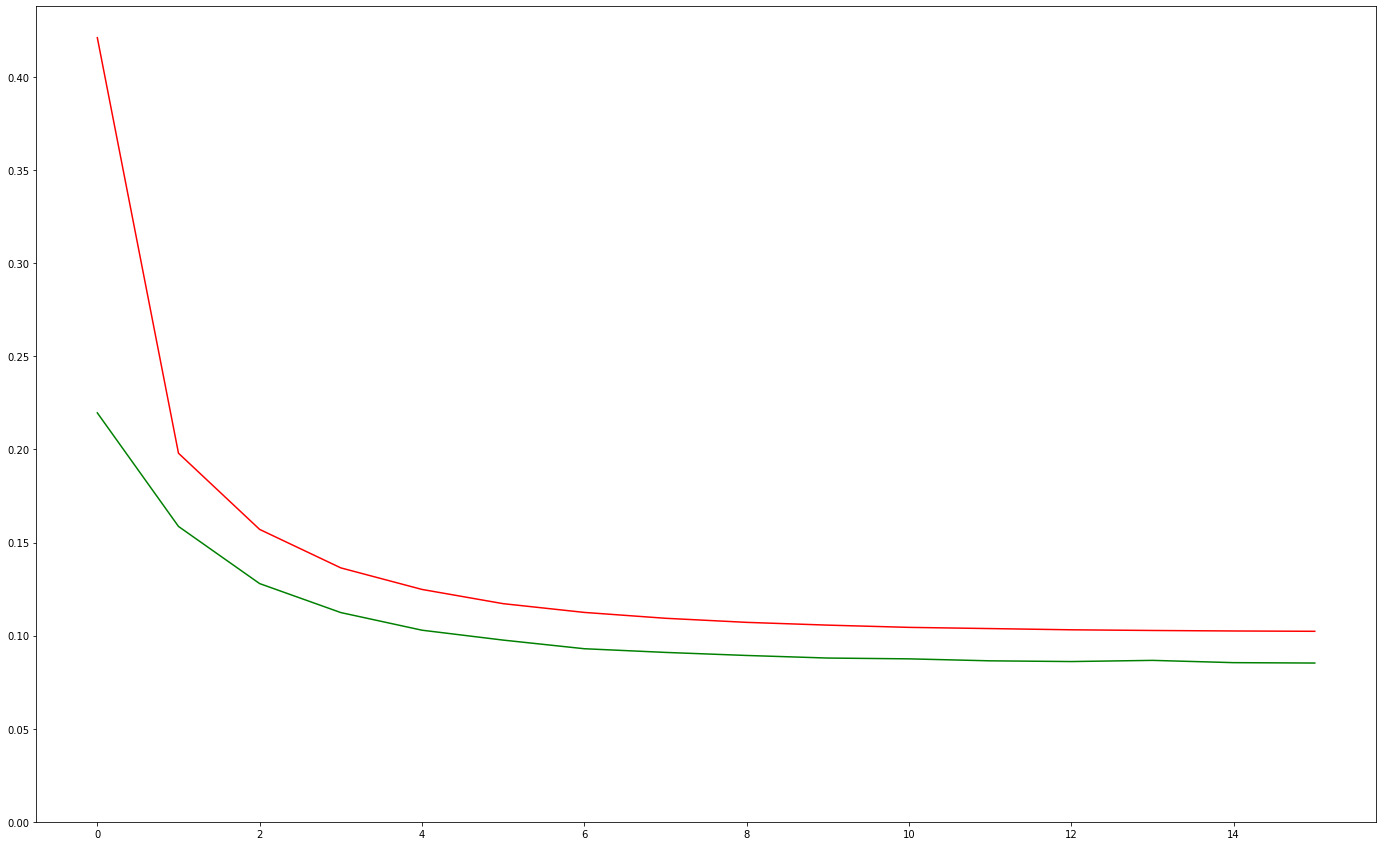

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.112481
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.076039
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.072306
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.060482
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.113678
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.054647
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.052273
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.136949
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.053806
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.327215
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.053081
Train Epoch: 17 [6400/10000 (64%)]	Loss: 0.051285


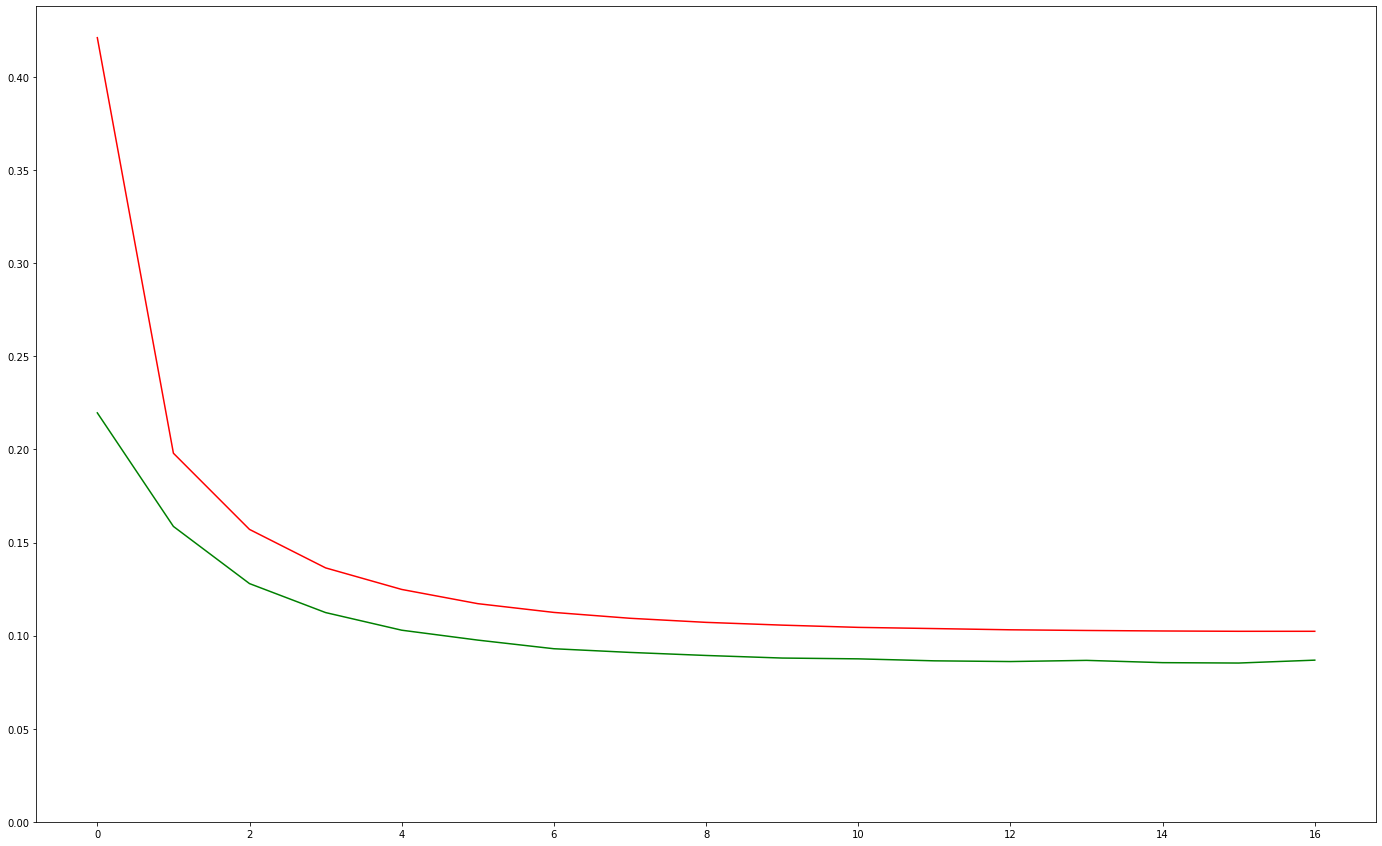

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.120423
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.046585
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.049611
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.113168
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.102221
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.109949
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.264724
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.062931
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.150017
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.128288
Train Epoch: 18 [0/10000 (0%)]	Loss: 0.051684
Train Epoch: 18 [6400/10000 (64%)]	Loss: 0.036568


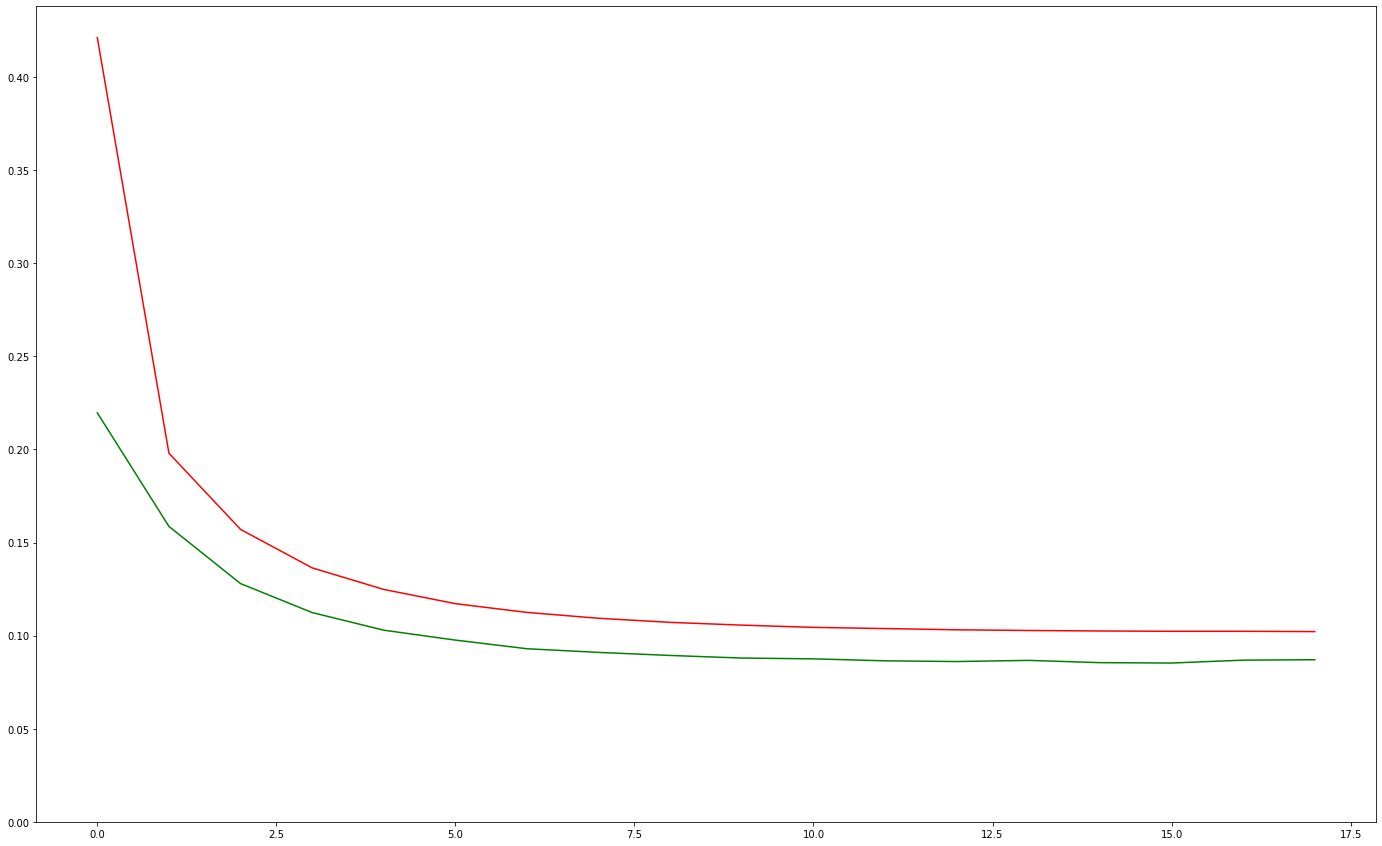

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.092427
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.062945
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.216041
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.012189
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.090950
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.071547
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.110382
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.137874
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.156899
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.099378
Train Epoch: 19 [0/10000 (0%)]	Loss: 0.028643
Train Epoch: 19 [6400/10000 (64%)]	Loss: 0.036739


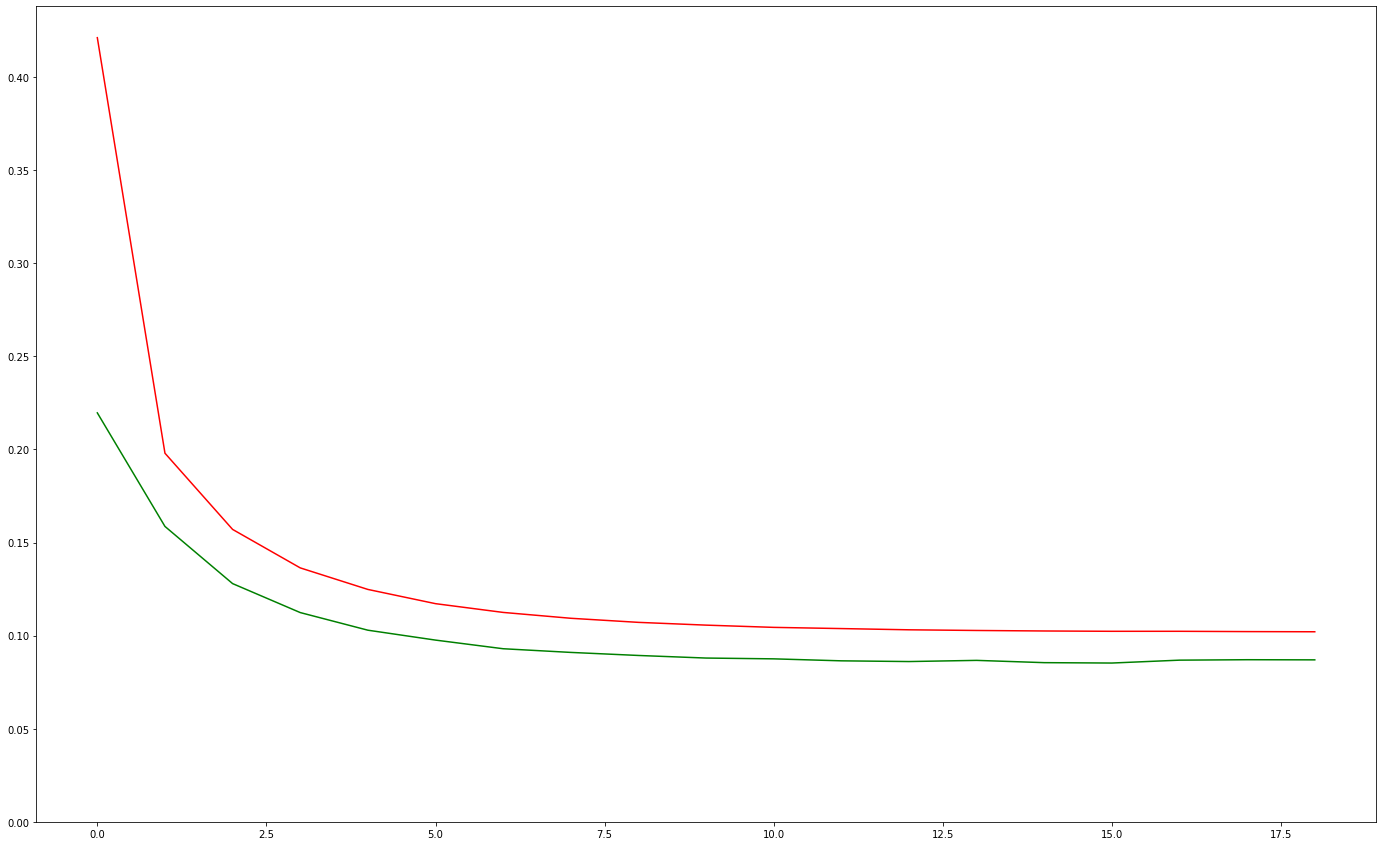

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.052837
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.158258
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.332468
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.091175
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.036831
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.041770
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.045715
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.024935
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.101274
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.061129
Train Epoch: 20 [0/10000 (0%)]	Loss: 0.130359
Train Epoch: 20 [6400/10000 (64%)]	Loss: 0.036010


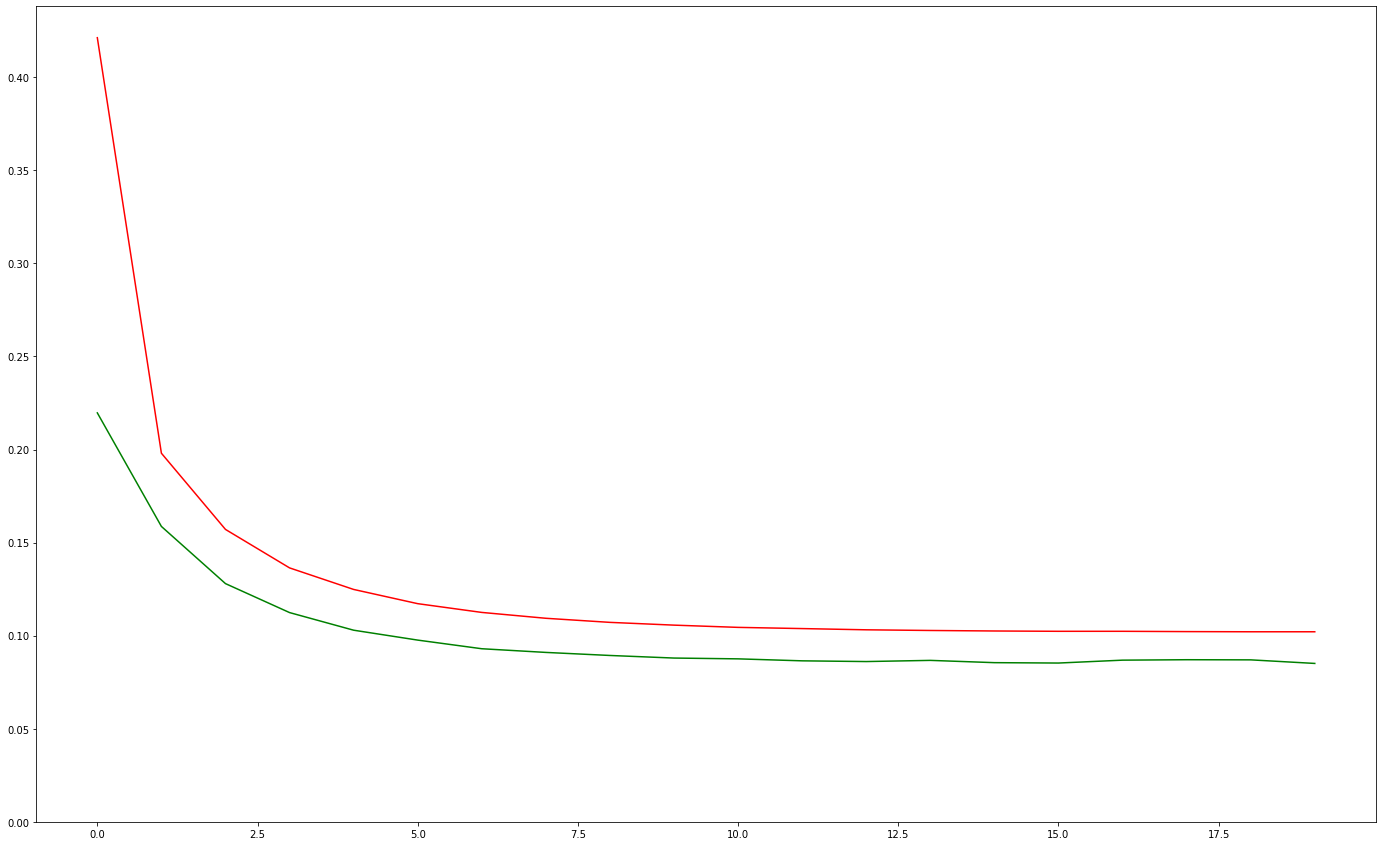

In [17]:
epochs          = 20
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Simple_net(100, 10).to(device)
#model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss)

    # test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

In [19]:
PATH = "mnist_hw5.pth"
torch.save(model.state_dict(), PATH)

In [20]:
model.load_state_dict(torch.load(PATH))
model.eval()

Simple_net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [9]:
def test(model, device, test_loader, loss_archive):
     model.eval()
     test_loss = 0
     correct = 0
     with torch.no_grad():
         for data, target in test_loader:
             data, target = data.to(device), target.to(device)
        
             output = model(data)
             test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
             correct += pred.eq(target.view_as(pred)).sum().item()

     test_loss = test_loss / len(test_loader)
     loss_archive.append (test_loss)

     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
         test_loss, correct, len(test_loader.dataset),
         100. * correct / len(test_loader.dataset)))

In [10]:
test(model, device, test_loader, test_loss)


Test set: Average loss: 0.0863, Accuracy: 9747/10000 (97%)



CIFAR-10

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

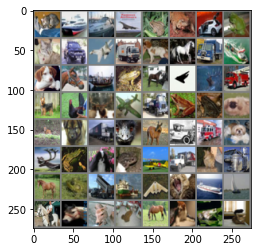

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.9 %
Accuracy for class: car   is 58.7 %
Accuracy for class: bird  is 28.7 %
Accuracy for class: cat   is 27.4 %
Accuracy for class: deer  is 43.6 %
Accuracy for class: dog   is 53.6 %
Accuracy for class: frog  is 63.3 %
Accuracy for class: horse is 65.0 %
Accuracy for class: ship  is 56.4 %
Accuracy for class: truck is 58.5 %


tensor([[8]])
tensor([[-3.3199, -3.2107, -2.2945, -1.4598, -4.7555, -2.0016, -4.1108, -2.9656,
         -1.1543, -2.7566]], grad_fn=<LogSoftmaxBackward0>)


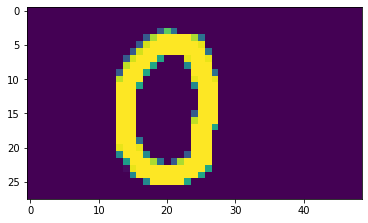

tensor([[2]])
tensor([[-1.6254, -2.9290, -1.6028, -2.3767, -2.4711, -2.8701, -2.3857, -2.4364,
         -2.5726, -2.8385]], grad_fn=<LogSoftmaxBackward0>)


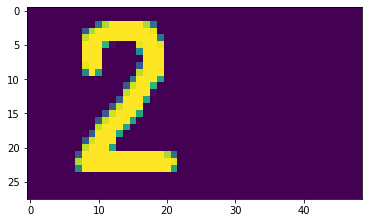

tensor([[4]])
tensor([[-1.7619, -3.3176, -2.7416, -3.1500, -1.6363, -2.6809, -2.1496, -2.3834,
         -2.3748, -2.1224]], grad_fn=<LogSoftmaxBackward0>)


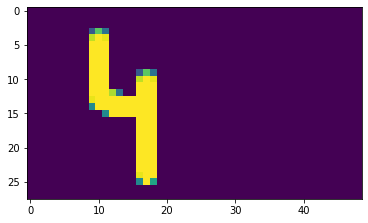

tensor([[2]])
tensor([[-1.6138, -3.4473, -1.5770, -1.8728, -3.0191, -3.1800, -2.7545, -2.0712,
         -2.6803, -2.8118]], grad_fn=<LogSoftmaxBackward0>)


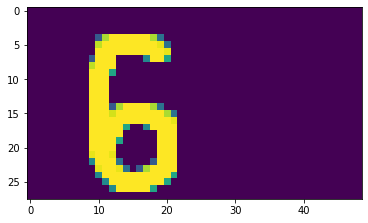

tensor([[8]])
tensor([[-2.5134, -3.4479, -2.3588, -3.3767, -2.0558, -2.4456, -1.4572, -3.4761,
         -1.3807, -3.5533]], grad_fn=<LogSoftmaxBackward0>)


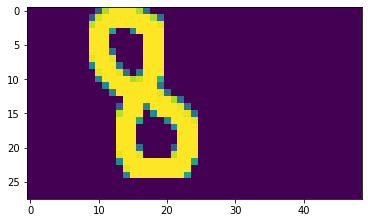

tensor([[0]])
tensor([[-1.5231, -3.1938, -2.3208, -3.0186, -1.8782, -2.9251, -2.1430, -2.5604,
         -2.3261, -2.3528]], grad_fn=<LogSoftmaxBackward0>)


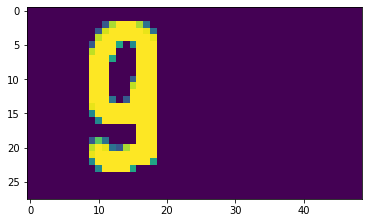

In [24]:

Images = glob.glob('/home/user/Documents/All/CVR/cifra/*.png')
data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
Images = ['0.png', '2.png','4.png', '6.png',  '8.png', '9.png']
for file in Images:
  img = Image.open(file)
  img = img.convert('L')
  image = data_transform(img)
  #     img_tensor = torch.from_numpy(img).float().to(device)
  #     print(img_tensor)
  #     img_tensor=img_tensor.view(-1,28*28)
  model.eval()
  #     img_tensor = transform(image)

  #     img_tensor.float().to(device)
  #     print(img_tensor)

  output = model(image)
  pred = output.argmax(dim=1, keepdim=True)
  print(pred)
  print(output)
  plt.imshow(img)
  plt.show()
    
    

    
    
    
   